# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Проект для сети отелей «Как в гостях». Для преодтвращения возможных убытков компании из-за внезапной отмены бронирования клиентом, необходимо разработать систему, предсказывающую отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь. На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

**Цель проекта:** изучить имеющиеся данные, сравнить поведение двух групп клиентов, посчитать чистую прибыль, построить различные модели и, сравнив их, выбрать лучшую модель, которая позволит максимально сократить прибыль. 

**Ход выполнения проекта:** данные получены от заказчика и находятся в двух файлах: `/datasets/hotel_train.csv`, `/datasets/hotel_test.csv`. О качестве данных ничего известно, поэтому возможно потребуется предобработка прежде чем можно будет приступить к построению моделей. Изучим данные, проведем анализ, построим модели, выберем метрику и произведем оценку их качества, расчитаем чистую прибыль и выберем оптимальную модель. Таким образом исследование прйодет в несколько этапов:

1. Загрузка данных
2. Подготовка данных
3. Сравнительный анализ выборок клиентов
4. Подготовка к расчету прибыли
5. Обучение и оценка качества моделей
5. Проверка модели

**Характеристики предметной области:**

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: молодец, что оформляешь описание!</div>

### Шаг 1. Откройте файлы с данными

#### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

#### Загрузка данных

In [2]:
data_train = pd.read_csv('datasets/hotel_train.csv')
data_test = pd.read_csv('datasets/hotel_test.csv')

Посмотрим на имеющиеся данные

In [3]:
display(data_train.head(), data_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [4]:
print('data_train')
display(data_train.info())
print('data_test')
display(data_test.info())

data_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                 

None

data_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                  

None

<AxesSubplot:>

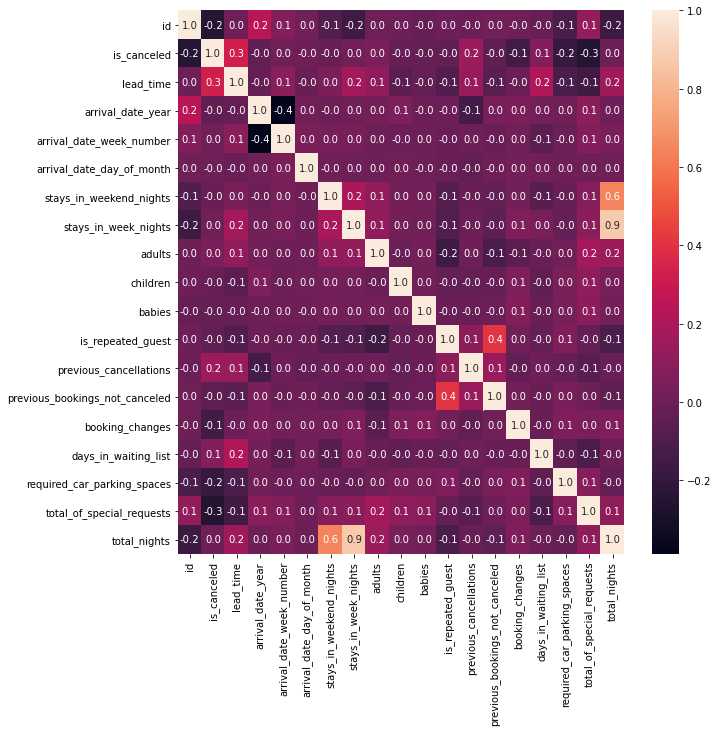

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data_train.corr(), annot=True, fmt='.1f')

В имеющихся датасетах 25 колонок, и 65229 строк(для таблицы hotel_train) и 32412(для таблицы hotel_test). Согласно полученной документации, в таблицах **hotel_train** и **hotel_test** содержатся одинаковые столбцы:

**Призанки:**
* `id` — номер записи;
* `adults` — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type` — тип заказчика:
* `Contract` — договор с юридическим лицом;
* `Group` — групповой заезд;
* `Transient` — не связано с договором или групповым заездом;
* `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:
    * `SC` — нет дополнительных опций;
    * `BB` — включён завтрак;
    * `HB` — включён завтрак и обед;
    * `FB` — включён завтрак, обед и ужин.
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type` — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

**Целевой признак:** 
* `is_canceled` — отмена заказа;

### Шаг 2. Предобработка и исследовательский анализ данных

Сразу удалим столбце id, т.к. он не несет в себе никакой ценности для анализа или обучения моделей

In [6]:
data_train = data_train.drop('id', axis=1)
data_test = data_test.drop('id', axis=1)

Закодируем столбец месяца соответствующими числовыми значениями

In [7]:
def monthToNum(row):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[row['arrival_date_month']]

In [8]:
data_train['arrival_date_month'] = data_train.apply(monthToNum, axis=1)

In [9]:
data_test['arrival_date_month'] = data_test.apply(monthToNum, axis=1)

Посмотрим на общие статистические характеристики датасета

In [10]:
data_train.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,0.368609,96.337917,2015.719021,7.450367,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,0.482431,96.127545,0.449481,3.099168,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,17.000000,2015.000000,5.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,64.000000,2016.000000,8.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,151.000000,2016.000000,10.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,2016.000000,12.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


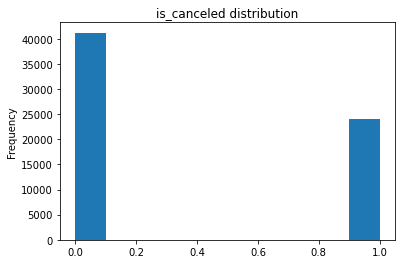

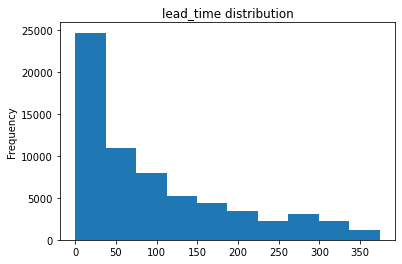

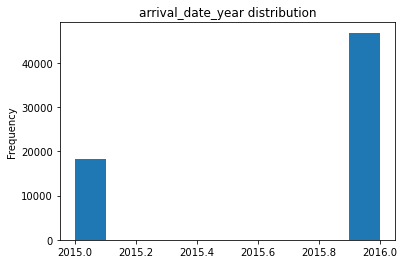

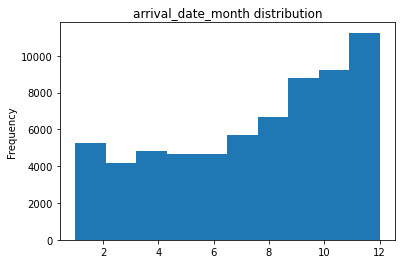

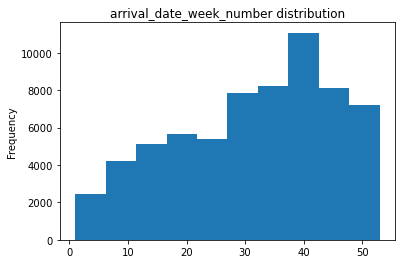

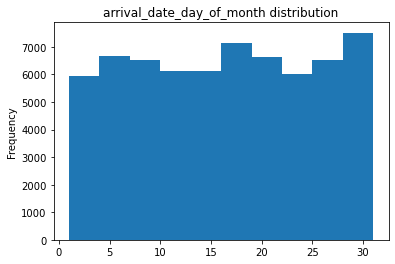

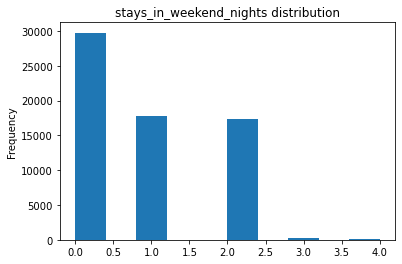

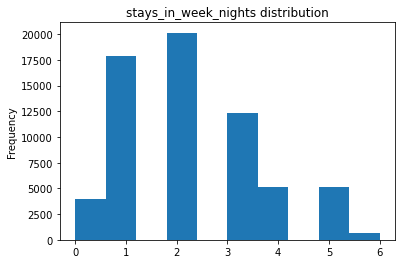

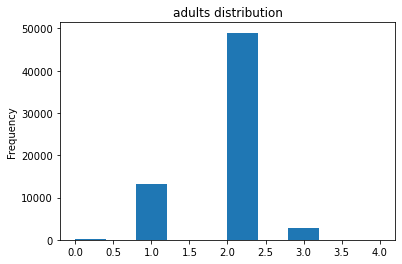

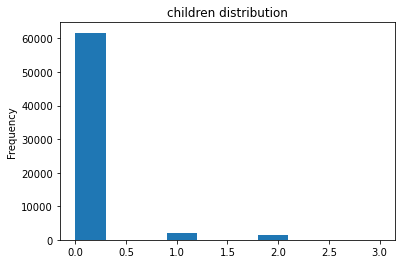

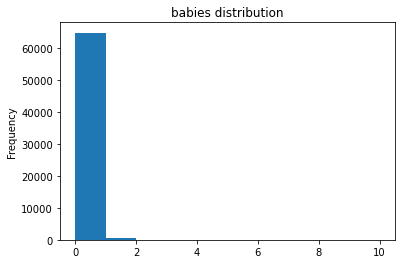

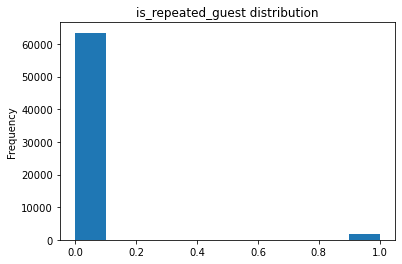

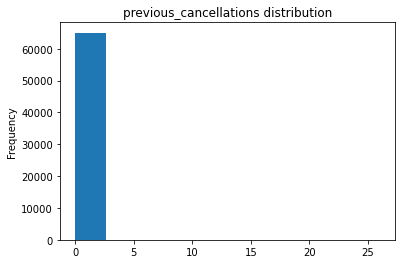

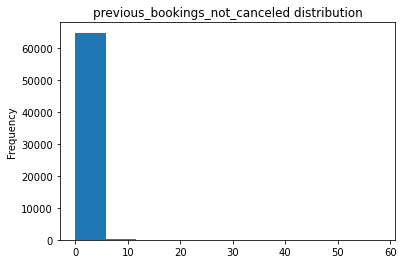

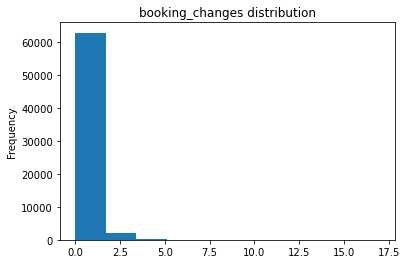

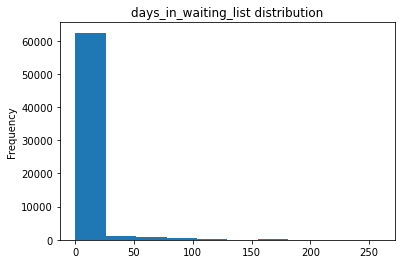

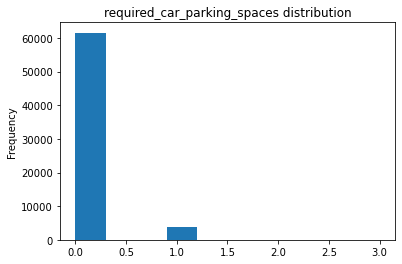

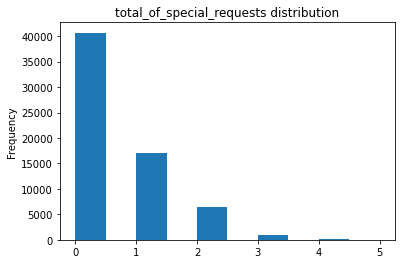

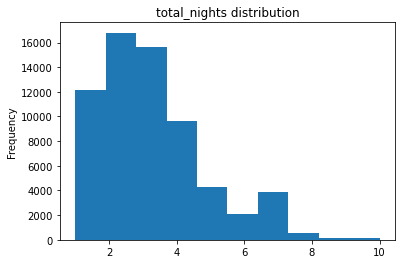

In [11]:
for column in data_train.columns:
    if (data_train[column].dtypes != object) and (column != 'id'):
        data_train[column].plot(kind='hist', title=f'{column} distribution')
        plt.show()

Проанализировав полученную информацию можно отметить следующие аномалии:

- Есть выбросы в столбце **days_in_waiting_list**, ожидание больше даже 60 дней выглядит достаточно нереалистично, а мы видим занчения больше 100
- Есть выбросы в столбце **babies**, визит с 10 младенцами представляется очень маловероятным
- Минимальное значение в столбце **adults** равно 0, а номер не будут сдавать детям без взрослых

Посмотрим, какой процент от всех данных занимают эти аномалии

In [12]:
data_train.query('adults < 1 or days_in_waiting_list > 60 or babies > 3').shape[0] / data_train.shape[0] * 100

2.3133882168973923

In [13]:
data_test.query('adults < 1 or days_in_waiting_list > 60 or babies > 3').shape[0] / data_test.shape[0] * 100

0.3671479698876959

Таких аномалий меньше 1% в обеих выборках, можно спокойно удалить их, т.к. их потеря не сильно скажется на общем кол-ве имеющихся данных, однако их удаление улучшит общее качество данных

In [14]:
data_train = data_train.query('adults >= 1 or days_in_waiting_list <= 60 or babies <= 3')
data_test = data_test.query('adults >= 1 or days_in_waiting_list <= 60 or babies <= 3')

Пропуски в данных отсутствуют

In [15]:
data_train.isna().sum()

is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

Явные дубликаты обнаружились, их необходимо удалить

In [16]:
data_train.duplicated().sum()

21377

In [17]:
data_test.duplicated().sum()

7717

In [18]:
data_train = data_train.drop_duplicates().reset_index(drop = True)
data_test = data_test.drop_duplicates().reset_index(drop = True)

In [19]:
print(data_train.duplicated().sum(), data_test.duplicated().sum())

0 0


In [20]:
for column in data_train.columns:
    if data_train[column].dtypes == object:
        print(column)
        print(data_train[column].unique())
        print('\n')

meal
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']


country
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 'GUY' 'LCA' 'ATA' 

Значения в столбце с типом забронированной комнаты и с типом дополнительных опций записаны некорректно, исправим это, удалив лишние пробелы.

In [21]:
data_train['reserved_room_type'] = data_train['reserved_room_type'].str.strip()
data_test['reserved_room_type'] = data_test['reserved_room_type'].str.strip()

data_train['meal'] = data_train['meal'].str.strip()
data_test['meal'] = data_test['meal'].str.strip()

Теперь все верно

In [22]:
data_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [23]:
data_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

#### Сравнительный анализ выборок клиентов

Выделим тех клиентов, которые не отменили свою запись.

In [24]:
data_uncanceled = data_train.query('is_canceled == 0')

И тех, кто отменил

In [25]:
data_canceled = data_train.query('is_canceled == 1')

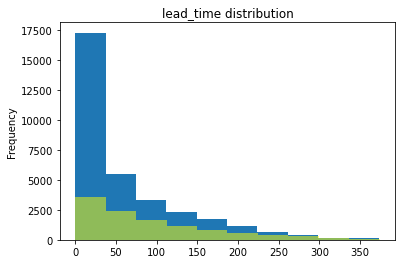

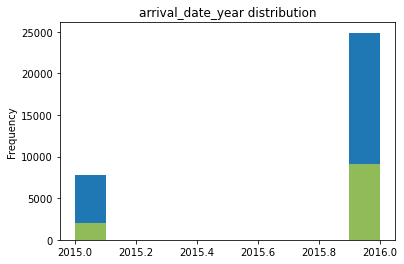

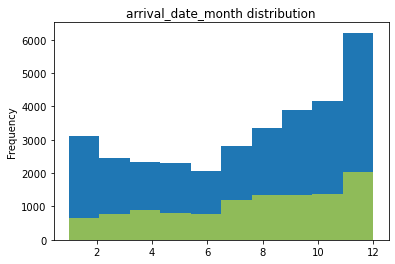

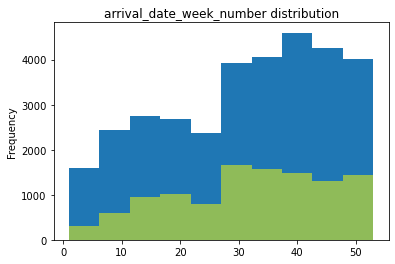

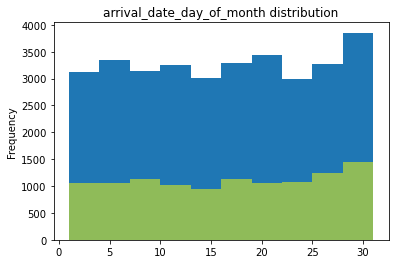

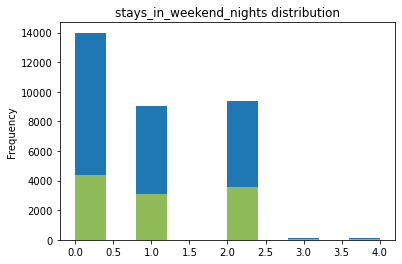

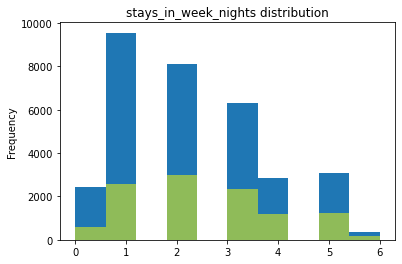

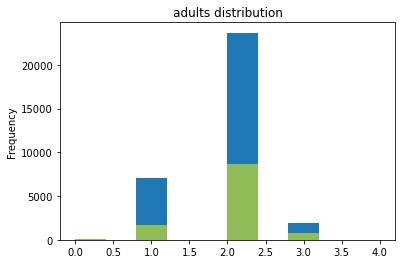

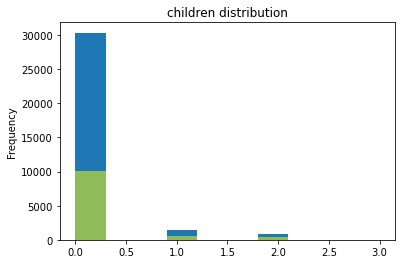

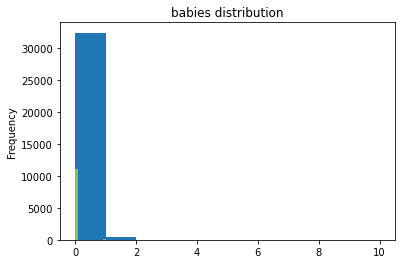

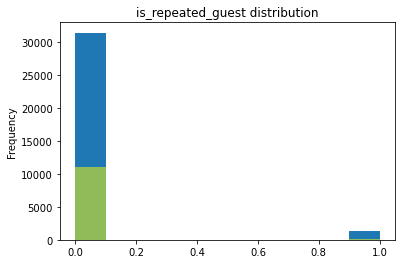

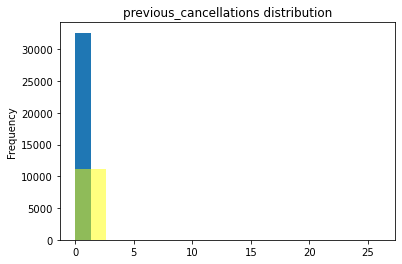

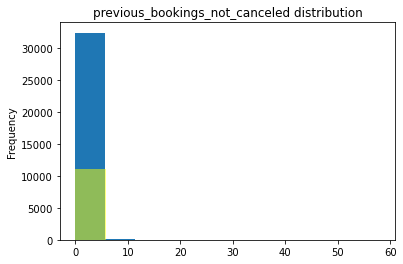

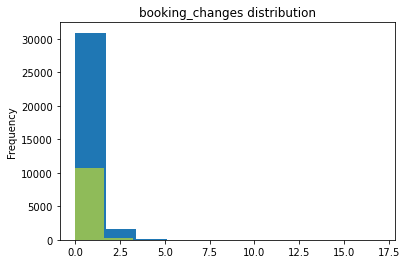

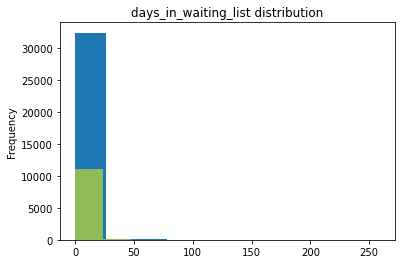

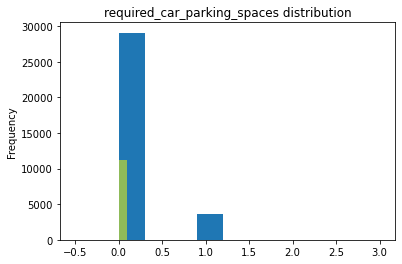

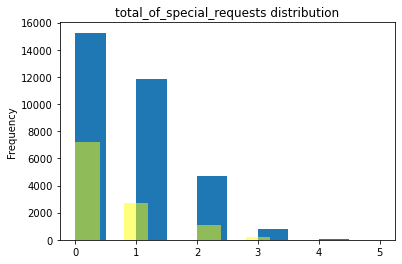

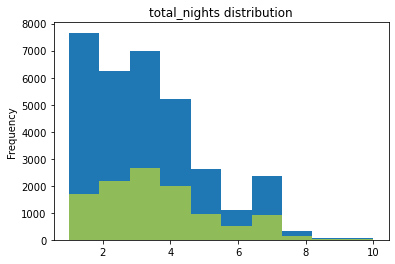

In [26]:
for column in data_train.columns:
    if (data_uncanceled[column].dtypes != object) and (column != 'id') and (column != 'is_canceled'):
        data_uncanceled[column].plot(kind='hist', title=f'{column} distribution')
        data_canceled[column].plot(kind='hist', title=f'{column} distribution', alpha=0.5, color='yellow')
        plt.show()

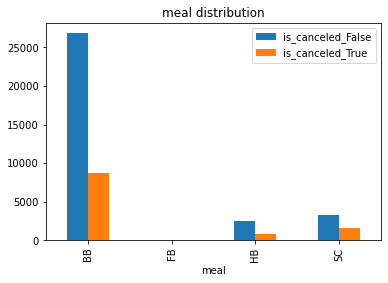

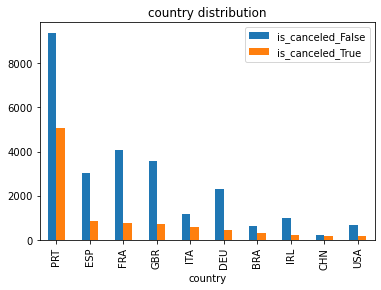

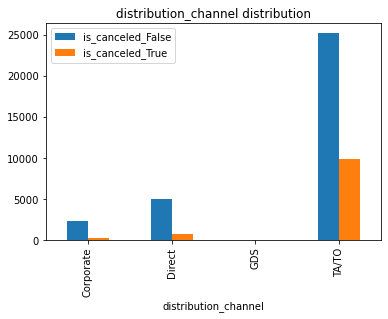

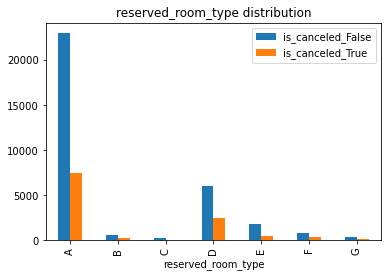

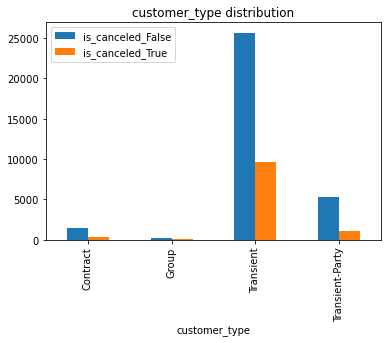

In [27]:
for column in data_train.columns:
    if (data_uncanceled[column].dtypes == object) and (column != 'country'):
        (data_uncanceled.pivot_table(index=column, values='is_canceled', aggfunc='count').
         merge(data_canceled.pivot_table(index=column, values='is_canceled', aggfunc='count'),
            on=column, suffixes=['_False', '_True']).
         plot(kind='bar', title=f'{column} distribution'))
        plt.show()
    elif (data_uncanceled[column].dtypes == object) and (column == 'country'):
        (data_uncanceled.pivot_table(index=column, values='is_canceled', aggfunc='count').
         merge(data_canceled.pivot_table(index=column, values='is_canceled', aggfunc='count'),
            on=column, suffixes=['_False', '_True']).
         sort_values(['is_canceled_True', 'is_canceled_False'], ascending=False).
         head(10).
         plot(kind='bar', title=f'{column} distribution'))
        plt.show()

В результате проведенного сравнения сделать следующие вывод, что в основном характер распределений имеющихся параметров у обеих групп одинаков, однако, есть и некоторые различия:

**Клиенты, впоследствие отменившие свою бронь:**
- значительно реже нуждаются в парковочном месте
- почти всегда уже отменяли свою бронь ранее
- не путешествуют с младенцами
- значительно чаще бронируют номер сильно заранее (300-365 дней) и значительно реже бронируют за очень маленький срок (0-30 дней)

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [28]:
summer_list = [6, 7, 8]
spring_list = [3, 4, 5]
    
PRICES = {'A' : [1000, 400],
         'B' : [800, 350],
         'C' : [600, 350],
         'D' : [550, 150],
         'E' : [500, 150],
         'F' : [450, 150],
         'G' : [350, 150],}

In [29]:
def profit_count(row):
    income = 0
    season_coef = 1
    if row['arrival_date_month'] in summer_list:
        season_coef = 1.4
    elif row['arrival_date_month'] in spring_list:
        season_coef = 1.2
    income += (PRICES[row['reserved_room_type']][0]* season_coef * row['total_nights'] 
                   - PRICES[row['reserved_room_type']][1] * (1 + row['total_nights'] // 2))
    return income

In [30]:
def unprofit_count(row, flag):
    lost = 0
    season_coef = 1
    if row['arrival_date_month'] in summer_list:
        season_coef = 1.4
    elif row['arrival_date_month'] in spring_list:
        season_coef = 1.2
    if flag == False:
        lost += (PRICES[row['reserved_room_type']][0] * season_coef + PRICES[row['reserved_room_type']][1])
    else:
        if row['is_canceled'] == row['predictions']:
            lost += 0.2 * (PRICES[row['reserved_room_type']][0] * season_coef + PRICES[row['reserved_room_type']][1])
        else:
            lost += (PRICES[row['reserved_room_type']][0] * season_coef + PRICES[row['reserved_room_type']][1])
    
    return lost

In [31]:
def clear_income_count(data, target_name, is_predicted):
    data_profit = data.query(f'{target_name} == 0')
    data_unprofit = data.query(f'{target_name} == 1')
    
    income = data_profit.apply(profit_count, axis=1)
    income = income.sum()
    print('Прибыль отеля:',income)
    
    loss = data_unprofit.apply(unprofit_count, flag=is_predicted, axis=1)
    loss = loss.sum()
    print('Убытки отеля:', loss)
    
    print('Чистая прибыль отеля:', income - loss)
    return (income - loss)

Оценим прибыль компании без внедрения системы депозитов.

In [32]:
clear_income_count(data_train, 'is_canceled', False)

Прибыль отеля: 75628120.0
Убытки отеля: 14576320.0
Чистая прибыль отеля: 61051800.0


61051800.0

При внедрении модели предсказания отмены, размер внесенного депозита будет составлять 80% от стоимости номера за одни сутки и затрат на разовую уборку, что потенциально может сократить убытки отеля на 80%.

Поскольку на разработку модели выделено 400 000, то, рассчитав чистую прибыль отеля на тестовых данных до и после внедрения модели, мы должны получить разницу между ними более чем в 400 000.

### Шаг 4. Разработка модели ML

С точки зрения машинного обучения перед нами стоит задача бинарной классификации

#### Подготовка датасета

Закодируем категориальные призанаки техникой OHE

In [33]:
data_ohe = pd.get_dummies(data_train,
                          columns=['reserved_room_type', 'customer_type', 'meal', 'distribution_channel'],
                          drop_first=True)
data_ohe.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,meal_FB,meal_HB,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO
0,0,7.0,2015,7,27,1,0,1,1.0,0.0,...,0,0,1,0,0,0,0,1,0,0
1,0,14.0,2015,7,27,1,0,2,2.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,0,0.0,2015,7,27,1,0,2,2.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,0,9.0,2015,7,27,1,0,2,2.0,0.0,...,0,0,1,0,1,0,0,1,0,0
4,1,85.0,2015,7,27,1,0,3,2.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [34]:
data_ohe_test = pd.get_dummies(data_test,
                          columns=['reserved_room_type', 'customer_type', 'meal', 'distribution_channel'],
                          drop_first=True)

Мы только что закодировали все категориальные признаки, кроме **country**, дело в том, что кодирование техникой OHE в данном случае не подойдет, поскольку количество уникальных значений стран в тренировочном и тестовом наборе разное, а это значит, что при применении OHE, модель, обученная на тренировочной выборке не сможет предсказывать значения по тестовой выборке. Для решения данной проблемы применим OrdinalEncoder

In [35]:
oe = OrdinalEncoder()
data_oe = data_ohe[['country']]
data_oe_test = data_ohe_test[['country']]

In [36]:
data_oe_fit = data_oe.append(data_oe_test)
data_oe_fit

,country
0,GBR
1,GBR
2,PRT
3,PRT
4,PRT
...,...
24690,DEU
24691,BEL
24692,BEL
24693,DEU


In [37]:
oe.fit(data_oe_fit[['country']])

data_oe = oe.transform(data_oe)
data_oe_test = oe.transform(data_oe_test)

In [38]:
data_ohe['country'] = data_oe
data_ohe_test['country'] = data_oe_test

In [39]:
data_ohe['country'].unique()

array([ 56., 132.,  48.,  73.,  53., 136., 121., 166.,  41.,  14.,  28.,
        33.,  63., 120.,   5., 137., 151., 130.,  49.,  40.,  78.,  51.,
        43., 110.,  26.,  97.,  24., 150.,   2.,  30., 104., 100., 145.,
        98.,  29.,  11.,  96., 159.,  77.,  72.,  38.,  10.,  35., 173.,
        45.,  88.,  36.,  69., 158.,   4.,  68.,  66.,  74.,  60.,  80.,
       165., 171.,  34.,  58.,  89.,  39.,  83., 155.,  44., 118.,  22.,
       168., 163.,   6.,  82.,  95., 114.,  21., 112., 124., 148.,  79.,
        18.,  31., 146.,  81., 153., 128., 131., 142.,  13.,  91.,   1.,
       170.,  12., 129., 123.,  47., 103.,  32., 107., 149., 113., 147.,
       160.,  70., 141., 127., 139.,  87.,  50.,  46.,  75.,   3.,  67.,
       125.,  57., 172., 135.,  85., 101.,  17.,  76., 167.,  71., 156.,
       119.,  15.,  99., 169., 161.,  55., 105., 157.,  61.,  84.,  94.,
       108., 126.,  16.,  92.,  62., 106.,  19., 116.,  23., 152., 133.,
        25.,   0., 144.,  42.,  37., 134., 162.,  6

Посмотрим на баланс классов в целевом призанке

In [40]:
data_ohe['is_canceled'].value_counts()

0    32704
1    11148
Name: is_canceled, dtype: int64

Записей класса "0" почти в 2 раза больше, чем записей класса "1". В выборке присутствует дисбаланс

In [41]:
target = data_ohe['is_canceled']
features = data_ohe.drop(['is_canceled', 'total_nights'], axis=1)

In [42]:
target_test = data_ohe_test['is_canceled']
features_test = data_ohe_test.drop(['is_canceled', 'total_nights'], axis=1)

Отмасштабируем имеющиеся признаки в масштабе от 0 до 1

In [43]:
sc1 = MinMaxScaler()
features = sc1.fit_transform(features)
features

array([[0.01871658, 0.        , 0.54545455, ..., 1.        , 0.        ,
        0.        ],
       [0.03743316, 0.        , 0.54545455, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.54545455, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.01871658, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.04545455, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.28609626, 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ]])

In [44]:
features_test = sc1.fit_transform(features_test)
features_test

array([[0.19839142, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.16621984, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.19034853, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.0616622 , 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.09115282, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.2922252 , 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ]])

Функция для проверки модели при помощи кросс-валидации

In [45]:
def counting_score(estimator, X, y, scoring):
    scores = cross_val_score(estimator, X, y, cv=5, scoring=scoring)
    final_score = pd.Series(scores).mean()
    print('Средняя оценка качества модели:', final_score)

В качестве параметра **scoring** для кросс-валидации будем использовать метрику recall, т.к. из всех записей "1" класса мы хотим верно предсказать максимально возвожную ее долю. Однако для предотвращения случая, при котором модель начнет выдавать подавляющему большинству случаев метку "1" класса, завышая метрику recall, будем следить и за метрикой precision.

#### Решающее дерево

In [46]:
model_DT = DecisionTreeClassifier(max_depth=3, random_state=1, class_weight="balanced")

In [47]:
%%time
counting_score(model_DT, features, target, 'recall')

Средняя оценка качества модели: 0.5735649721264939
Wall time: 280 ms


In [48]:
%%time
counting_score(model_DT, features, target, 'precision')

Средняя оценка качества модели: 0.32400674245663375
Wall time: 272 ms


#### Случайный лес

In [49]:
model_RF = RandomForestClassifier(max_depth=17, random_state=1, class_weight="balanced")

In [50]:
%%time
counting_score(model_RF, features, target, 'recall')

Средняя оценка качества модели: 0.3180485528107881
Wall time: 11.4 s


In [51]:
%%time
counting_score(model_RF, features, target, 'precision')

Средняя оценка качества модели: 0.30204189153594513
Wall time: 11.6 s


#### Логистическая регрессия

In [52]:
model_LR = LogisticRegression(random_state=1, max_iter=300, penalty='none', solver='lbfgs', class_weight="balanced")

<div class="alert alert-warning">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: если не лезть глубоко в дебри, то это предупреждение означает, что модели не хватило памяти при расчете ошибки(читай — модель недообучилась). Поэтому поменять solver, либо увеличить количество итераций все-таки нужно, несмотря на метрики. Но если все-таки нужно скрыть предупреждения, то сделать это можно так:
    
    from warnings import simplefilter
    from sklearn.exceptions import ConvergenceWarning
    simplefilter("ignore", category=ConvergenceWarning)

</div>

In [53]:
%%time
counting_score(model_LR, features, target, 'recall')

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

Средняя оценка качества модели: 0.6486470033214837
Wall time: 3.52 s


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
%%time
counting_score(model_LR, features, target, 'precision')

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

Средняя оценка качества модели: 0.38844503789449847
Wall time: 3.43 s


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Подбор гиперпараметров

Для полученных моделей проведем подбор гиперпарметров, чтобы улучшить качество обучения

##### Решающее дерево

In [55]:
depth_range = np.array(range(1,100,5))
tuned_params_DT = {'max_depth' : depth_range}

In [56]:
tuned_DT = GridSearchCV(DecisionTreeClassifier(random_state=1, class_weight='balanced'), tuned_params_DT, cv=5, scoring='recall')

In [57]:
%%time
tuned_DT.fit(features, target)

Wall time: 16.3 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             param_grid={'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
             scoring='recall')

In [58]:
tuned_DT.best_params_, tuned_DT.best_score_

({'max_depth': 1}, 0.924210579257927)

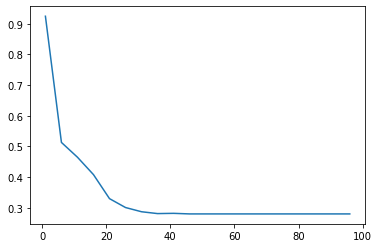

In [59]:
plt.plot(depth_range, tuned_DT.cv_results_['mean_test_score'])

##### Случайный лес

In [60]:
depth_range = np.array(range(1, 11, 2))
est_range = np.array(range(1, 11, 2))
tuned_params_RF = {'max_depth' : depth_range, 
                   'n_estimators' : est_range}

In [61]:
tuned_RF = GridSearchCV(RandomForestClassifier(random_state=1, class_weight='balanced'), tuned_params_RF, cv=5, scoring='recall')

In [62]:
%%time
tuned_RF.fit(features, target)

Wall time: 8.47 s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1),
             param_grid={'max_depth': array([1, 3, 5, 7, 9]),
                         'n_estimators': array([1, 3, 5, 7, 9])},
             scoring='recall')

In [63]:
tuned_RF.best_params_, tuned_RF.best_score_

({'max_depth': 1, 'n_estimators': 9}, 0.7519131223758568)

##### Логистическая регрессия


In [64]:
penalty_range = ['l2', 'none']
C_range = [1.87, 1.9, 1.93]
iter_range = np.array(range(100, 401, 100))
tuned_params_LR = {'penalty' : penalty_range,
                  'C' : C_range,
                  'max_iter' : iter_range}

In [65]:
tuned_LR = GridSearchCV(LogisticRegression(random_state=1, C=1.9, class_weight='balanced'), tuned_params_LR, cv=5, scoring='recall')

In [66]:
%%time
tuned_LR.fit(features, target)

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproces

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):

Wall time: 1min


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=LogisticRegression(C=1.9, class_weight='balanced',
                                          random_state=1),
             param_grid={'C': [1.87, 1.9, 1.93],
                         'max_iter': array([100, 200, 300, 400]),
                         'penalty': ['l2', 'none']},
             scoring='recall')

In [67]:
tuned_LR.best_params_, tuned_LR.best_score_

({'C': 1.87, 'max_iter': 400, 'penalty': 'none'}, 0.6499922545652799)

#### Проверка модели

Сравним нашим модели с помощью кросс-валидации

**Решающее дерево**

In [68]:
counting_score(tuned_DT.best_estimator_, features, target, 'recall')

Средняя оценка качества модели: 0.924210579257927


In [69]:
counting_score(tuned_DT.best_estimator_, features, target, 'precision')

Средняя оценка качества модели: 0.2931007319424853


**Случайный лес**

In [70]:
counting_score(tuned_RF.best_estimator_, features, target, 'recall')

Средняя оценка качества модели: 0.7519131223758568


In [71]:
counting_score(tuned_RF.best_estimator_, features, target, 'precision')

Средняя оценка качества модели: 0.2986938559340905


**Логистическая регрессия**

In [72]:
counting_score(tuned_LR.best_estimator_, features, target, 'precision')

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):

Средняя оценка качества модели: 0.3888993584689413


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [73]:
counting_score(tuned_LR.best_estimator_, features_test, target_test, 'recall')

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Средняя оценка качества модели: 0.6652536929993578


<div class="alert alert-success">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: интересные вопросы ты задаешь, молодец! 

В этом проекте у тебя получаются достаточно хорошие метрики, но если хочется попробовать их улучшить, то можно попробовать уже известные тебе способы: увеличить границы подбора гиперпараметров, попробовать использовать другое кодирование(например, <a href="https://contrib.scikit-learn.org/category_encoders/targetencoder.html">TargetEncoder</a>), проверить другое масштабирование, например, StandardScaler, а также попробовать другие модели(тот же градиентный бустинг). Однозначного ответа, какие модели использовать и как проводить предобработку никогда нет, иначе наша профессия была бы не очень нужна :)
    
Относительно правильного подбора гиперпараметров, тут, конечно, сложно: нужно разбираться с каждым типом моделей отдельно, изучая их архитектуру. В следующих спринтах вам расскажут по поводу внутреннего устройства линейной регрессии(и, соответственно, логистической). Но более глубокое понимание и, порой, интуиция придет только с опытом. В качестве примера, можешь попробовать почитать <a href="https://arxiv.org/pdf/1407.7502.pdf">диссертацию</a> на тему случайного леса, но вряд ли на данном этапе это будет очень полезно. Так что я бы посоветовал погуглить, какие гиперпараметры для каждого типа моделей настраиваются чаще всего, и от этого отталкиваться, пока этого должно хватить, с опытом придет большее понимание
    
По поводу способов подбора гиперпараметров, чаще всего используются именно GridSearch и RandomSearch, но иногда используется еще кривая валидации. Благодаря ее визуализации можно увидеть, когда метрики перестают расти. Мне еще нравится использовать <a href="https://github.com/hyperopt/hyperopt" target="blank_">hyperopt</a>, он работает быстрее, чем GridSearch и есть возможность сохранять историю обучения «из коробки»
    
Подробнее про кривую обучения:
* https://scikit-learn.org/stable/modules/learning_curve.html
* https://www.geeksforgeeks.org/validation-curve/
* https://towardsdatascience.com/validation-curve-explained-plot-the-influence-of-a-single-hyperparameter-1ac4864deaf8
</div>

Среди всех вычисленных оценок самая лучшая у Логистической регрессии, так как по оценкам метрик видно, что хоть метрика recall у нее самая низкая по величине из всех, но остальные модели достигли этого в результате переобучения, о чем свидетельствует метрика precision

In [74]:
model_LR = tuned_LR.best_estimator_

In [75]:
%%time
model_LR.fit(features, target)

C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Wall time: 1.26 s


C:\Users\Tim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.87, class_weight='balanced', max_iter=400,
                   penalty='none', random_state=1)

In [76]:
predictions = model_LR.predict(features_test)

In [77]:
recall_score(target_test, predictions)

0.548747591522158

In [78]:
precision_score(target_test, predictions)

0.5109436670254754

In [79]:
data_test['predictions'] = predictions

In [80]:
data_test['is_canceled'].value_counts()

0    16910
1     7785
Name: is_canceled, dtype: int64

In [81]:
data_test['predictions'].value_counts()

0    16334
1     8361
Name: predictions, dtype: int64

In [82]:
data_test.query('is_canceled == predictions').shape[0] / data_test.shape[0]

0.6921644057501518

In [83]:
clear_income_wout_ml = clear_income_count(data_test, 'is_canceled', False)

Прибыль отеля: 43254800.0
Убытки отеля: 10571770.0
Чистая прибыль отеля: 32683030.0


In [84]:
clear_income_with_ml = clear_income_count(data_test, 'is_canceled', True)

Прибыль отеля: 43254800.0
Убытки отеля: 5863346.0
Чистая прибыль отеля: 37391454.0


Посмотрим, сколько чистой прибыли отелю  повзолит получить введение системы депозитов:

In [85]:
print('Разница в прибыли:', clear_income_with_ml - clear_income_wout_ml)

Разница в прибыли: 4708424.0


Система позволила сократить убытки и это принесло около 4,7 миллионов, что достаточно хороший показатель, и он значительно больше 400 000, затраченных на разработку системы.

### Шаг 5. Опишите портрет «ненадёжного» клиента

Основываясь на сравнительном анализе выборок клиентов можно выделить следующие характеристики клиента, которые значительно с большей вероятностью присущи тем людям, которые склонны к отмене брони:

* ранее уже отменял брони
* оформляет бронь заранее за очень большой промежуток времени(300-360) дней
* не нуждается в парковочном месте
* путешествует без младенцев

Во всем остальном такие клиенты схожи с той частю клиентуры, кто не склонен к отмене брони.

<div class="alert alert-warning">
<h2>Комментарий ревьюера v2<a class="tocSkip"></a></h2>
    
**Есть совет** ⚠️: некоторые особенности можно заметить и по графикам: например, граждане Португалии отменяют бронь почти в половине случаев, в отличии от других самых частотных стран. Для бизнеса это может быть полезным инсайтом</div>

### Шаг 6. Напишите общий вывод

В ходе проведенного исследования были изучены полученные данные и разработана система, предсказывающая отказ от брони, также можно отметить следующие пункты:

* Внедрение системы позволило получить на 20,6 млн чистой прибыли больше, чем без использования этой системы, за тот же тестовый период.
* Проанализированы и выделены основные черты, которые присущи клиентам, склонным к отказу от брони.